# Libraries

In [27]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # tf warning

# libraries
import numpy as np
import time
import regex as re
from IPython import display as ipythondisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
import collections
import random
from sklearn.model_selection import train_test_split
import json
from music21 import converter

# fixa para executar na CPU (determinismo)
devices = tf.config.list_physical_devices()
tf.config.experimental.set_visible_devices(devices[0]) 

# semente aleatória
SEED=301831
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Dados

Leitura das músicas em formato `.abc`

In [28]:
def extract_song_snippet(text):
    pattern = '(^|\n\n)(.*?)\n\n'
    search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
    songs = [song[1] for song in search_results]
    # print("Found {} songs in text".format(len(songs)))
    return songs

In [29]:
cwd = os.getcwd()
songs = []

# escolher dataset
dataset = 'abcnotation_sample' # ['irish','abcnotation_sample']

In [30]:
with open(os.path.join(cwd, 'data', dataset, f'{dataset}.abc'), 'r', encoding='windows-1252') as f:
    text = f.read()
    songs = extract_song_snippet(text)

# Exemplo de musica
example_song = songs[0]
print("\nExample song: ")
print(example_song)


Example song: 
X: 0
T: Hail, Sweet Babe, So Pure And Holy
Z: E. Pettman
Z: Copyright © 2003 by Douglas D. Anderson
Z: Released To The Public Domain
L: 1/4
M: 6/4
Q: 1/4=124
V: P1 name="Staff"
%%MIDI program 1 19
K: F
[V: P1]  A2 G B2 A | c2 c =B2 _B | A2 A B2 D | (E F) ^F (G2 ^G) | A2 G B2 A | (d e) d d2 ^c | d2 A c2 B | A2 G c3 | (F G) F B2 A | (G D) E F3|]
w: Hail, Sweet Babe, so pure and ho- ly! Hail, fair Son of Ma-_ ry’s blest!_ Ro- yal In- fant in_ a man- ger, Thou art gen- tly laid to rest Thou_ art gen- tly laid_ to rest.


In [31]:
len(songs) # quantidade de musicas no arquivo .abc

5000

# Preprocessamento

## Limpar arquivo `.abc`

Remover campos que não são essenciais para a construção da música:
* Título
* Compositor
* Letra
* etc.

In [32]:
def clean_abc(abc_song, show_rslt=False):
    # original .abc
    text = abc_song
    new_text = text

    # # remove index field
    # new_text = re.sub('(X:).*\n', '', new_text)

    # remove title field
    new_text = re.sub('(T:).*\n', '', new_text)

    # remove composer field
    new_text = re.sub('(C:).*\n', '', new_text)

    # remove source field
    new_text = re.sub('(S:).*\n', '', new_text)

    # remove geographical origin field
    new_text = re.sub('(O:).*\n', '', new_text)

    # remove textual notes field
    new_text = re.sub('(N:).*\n', '', new_text)

    # remove identity of transcriber/source of transcription field
    new_text = re.sub('(Z:).*\n', '', new_text)

    # remove lyrics
    new_text = re.sub('([wW]:).*\n','',new_text)
    new_text = re.sub('[wW]:','',new_text)


    # remove comments
    new_text = re.sub('(%).*\n','',new_text)

    # remove other fields
    new_text = re.sub('(R:).*\n','',new_text)
    new_text = re.sub('(I:).*\n','',new_text)
    new_text = re.sub('(B:).*\n','',new_text)

    if show_rslt==True:
        # print results
        print('original: '+str(len(text))+' characters'+'\n' + text)
        print()
        print('after modification: '+str(len(new_text))+' characters'+'\n' + new_text)

    return new_text

In [33]:
for i in range(len(songs)):
    songs[i] = clean_abc(songs[i])

In [34]:
# musica preprocessada
example_song = songs[0]
print("\nExample song: ")
print(example_song)


Example song: 
X: 0
L: 1/4
M: 6/4
Q: 1/4=124
V: P1 name="Staff"
K: F
[V: P1]  A2 G B2 A | c2 c =B2 _B | A2 A B2 D | (E F) ^F (G2 ^G) | A2 G B2 A | (d e) d d2 ^c | d2 A c2 B | A2 G c3 | (F G) F B2 A | (G D) E F3|]
 Hail, Sweet Babe, so pure and ho- ly! Hail, fair Son of Ma-_ ry’s blest!_ Ro- yal In- fant in_ a man- ger, Thou art gen- tly laid to rest Thou_ art gen- tly laid_ to rest.


## Obter Caracteres Únicos

Corpus ou Vocabulário

In [35]:
def extract_vocab(text):
    vocab = sorted(set(text))
    return {u:i for i, u in enumerate(vocab)}

In [36]:
songs_joined = "\n\n".join(songs) 

# caracteres únicos disponíveis
vocab = extract_vocab(songs_joined)

print('Total Characters:', len(songs_joined))
print('Total Vocab:', len(vocab))

Total Characters: 1849309
Total Vocab: 125


## Funções para mapear caractere para índice e vice versa

In [37]:
# Create a mapping from character to unique index
def char2idx(string, vocab=None):
    if vocab==None:
        vocab = extract_vocab(string)
    vectorized_list = np.array([vocab[s] for s in string])
    return vectorized_list


# Create a mapping from indices to characters
def idx2char(idx, vocab):
    keys = list(vocab.keys())
    string = ''
    if isinstance(idx, collections.Iterable):
        for i in idx:
            string += keys[i]
    else:
        string += keys[idx]
    return string

# Modelo

In [38]:
# Segmentando em Treino e Teste (80/20)
songs_train, songs_test = train_test_split(songs, train_size = 0.80)
songs_train_joined = "\n\n".join(songs_train)
songs_test_joined = "\n\n".join(songs_test)

## Estruturando Dados para Input

In [39]:
def prepare_train_data(vectorized_string, seq_length, method, batch_size=None, vocab=None):

  # Todas as Combinações + One Hot Encoding (Dummies)
  if method == 'full':
    x_train = []
    y_train = []

    n = len(vectorized_string)

    for i in range(0, n-seq_length, 1):
      seq_in = vectorized_string[i:i + seq_length]
      seq_out = vectorized_string[i + seq_length]
      x_train.append(seq_in)
      y_train.append(seq_out)

    n_patterns = len(x_train)

    x_train = np.reshape(x_train, (n_patterns, seq_length, 1))
    # normalize
    x_train = x_train / float(len(vocab))
    # one hot encode the output variable
    y_train = tf.keras.utils.to_categorical(y_train)


  # Lotes com tamanho específico + Word Embedding
  if method == 'batch':
    n = len(vectorized_string) - 1
    idx = np.random.choice(n-seq_length, batch_size)
    seq_in = [vectorized_string[i:i+seq_length] for i in idx]
    seq_out = [vectorized_string[i+1: i+1+seq_length] for i in idx]

    x_train = np.reshape(seq_in, [batch_size, seq_length])
    y_train = np.reshape(seq_out, [batch_size, seq_length])

  return x_train, y_train

## RNN LSTM

### Setup

In [40]:
def build_model_wordEmbed(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    tf.keras.layers.LSTM(
    units=rnn_units, 
    activation='tanh', # ['tanh','sigmoid']
    recurrent_activation='sigmoid',
    recurrent_initializer='glorot_uniform',
    use_bias=True,
    bias_initializer='zeros',
    return_sequences=True, 
    stateful=True
    ),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    tf.keras.layers.Dense(units=vocab_size)
  ])

  return model

In [41]:
def compute_loss_wordEmbed(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

def train_step_wordEmbed(x, y): 
  with tf.GradientTape() as tape:
    y_hat = model(x)
    loss = compute_loss_wordEmbed(y, y_hat)

  grads = tape.gradient(loss, model.trainable_variables)  
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss

In [42]:
class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

### Params

In [43]:
# parameters
epochs = 2000  # Increase this to train longer
batch_size = 4 # [4,16]  # Experiment between 1 and 64
seq_length = 50 # [50,200]  # Experiment between 50 and 500
learning_rate = 1e-3 # [1e-3,1e-5]  # Experiment between 1e-5 and 1e-1 
vocab_size = len(vocab)
embedding_dim = 256 # [256, 512] # Experiment between 8 and 1024
lstm_units = 256 # [256, 1024]  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'my_ckpt')

# train | test
vec_songs_train = char2idx(songs_train_joined, vocab)
vec_songs_test = char2idx(songs_test_joined, vocab)

### Training

In [44]:
model = build_model_wordEmbed(vocab_size, embedding_dim, lstm_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)

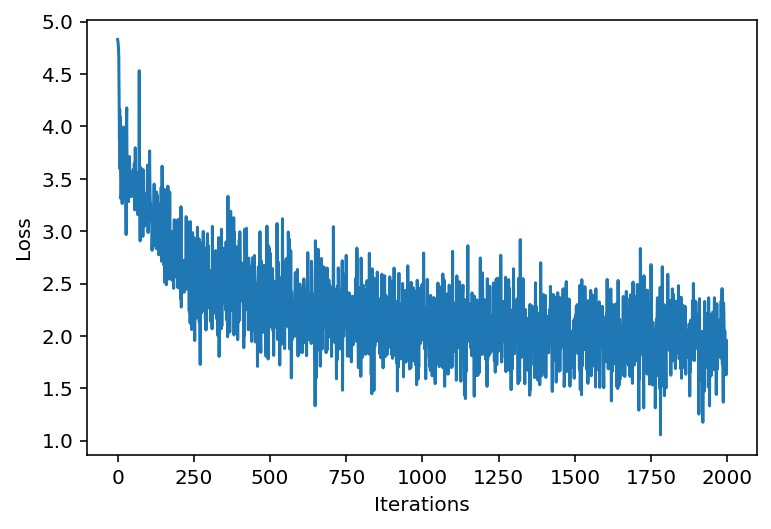

100%|██████████| 2000/2000 [08:10<00:00,  4.08it/s]


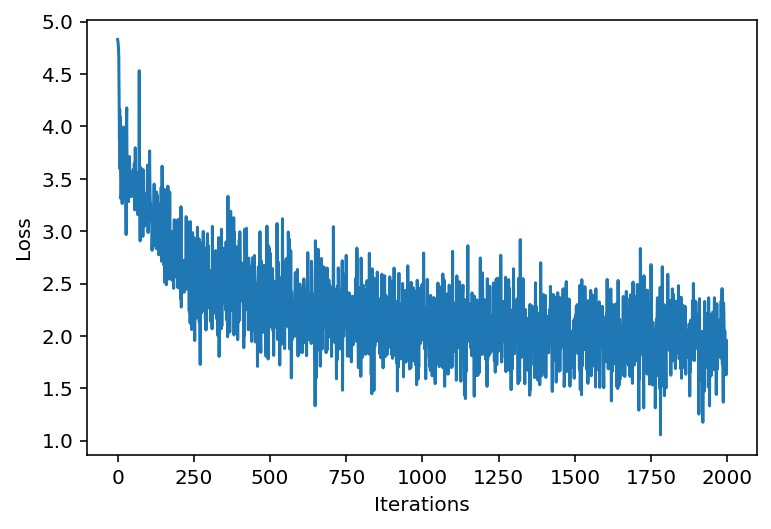

In [45]:
train_loss_history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(epochs)):

    # Grab a batch and propagate it through the network
    x_train, y_train = prepare_train_data(vectorized_string=vec_songs_train, seq_length=seq_length, method='batch', batch_size=batch_size)
    train_loss = train_step_wordEmbed(x_train, y_train)
    train_loss = train_loss.numpy().mean()

    # Update the progress bar
    train_loss_history.append(train_loss)
    plotter.plot(train_loss_history)

    # Update the model with the changed weights!
    if iter % 100 == 0:     
        model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [46]:
# Compute Metrics
x_test, y_test = prepare_train_data(vectorized_string=vec_songs_test, seq_length=seq_length, method='batch', batch_size=batch_size)
loss = []

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i in tqdm(range(epochs)):
    y_hat = model(x_test)
    test_loss = compute_loss_wordEmbed(y_test, y_hat)
    test_loss = test_loss.numpy().mean()
    loss.append(test_loss)
test_loss = np.mean(loss)

100%|██████████| 2000/2000 [02:24<00:00, 13.81it/s]


In [47]:
print('train categorical cross-entropy loss =', train_loss)
print('train perplexity (2**) =', 2**train_loss)
print('train perplexity (exp) =', tf.exp(train_loss).numpy())
print()
print('test categorical cross-entropy loss =', test_loss)
print('test perplexity (2**) =', 2**test_loss)
print('test perplexity (exp) =', tf.exp(test_loss).numpy())

train categorical cross-entropy loss = 2.05834
train perplexity (2**) = 4.165068066483516
train perplexity (exp) = 7.832957

test categorical cross-entropy loss = 1.8827847
test perplexity (2**) = 3.6878621359568724
test perplexity (exp) = 6.57178


## Gerar Texto no Formato `.abc`

In [48]:
def generate_text_wordEmbed(model, start_string, vocab, generation_length):
  input_eval = [char2idx(s, vocab) for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  text_generated = []

  model.reset_states()
  
  for i in range(generation_length):
    predictions = model(input_eval)
    predictions = tf.squeeze(predictions, 0)
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    input_eval = tf.expand_dims([predicted_id], 0)
    text_generated.append(idx2char(predicted_id, vocab))
    
  text = (start_string + ''.join(text_generated))
    
  return text

In [49]:
gen_model = build_model_wordEmbed(vocab_size, embedding_dim, lstm_units, batch_size=1)
gen_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
gen_model.build(tf.TensorShape([1, None]))

n_songs = 10
new_songs = []

tqdm._instances.clear()
with tqdm(total=n_songs) as pbar:
    while len(new_songs) < n_songs:
        n0 = len(new_songs)
        generated_text = generate_text_wordEmbed(gen_model, start_string='X:', vocab=vocab, generation_length=1000)
        generated_songs = extract_song_snippet(generated_text)
        for song in generated_songs:
            new_songs.append(song)
        if len(new_songs) > n0:
            pbar.update(len(new_songs)-n0)
    
new_songs = new_songs[0:n_songs]

11it [01:24,  7.68s/it]                       


# Salvar Resultados em `.json`

In [50]:
layer1 = model.layers[0]
layer2 = model.layers[1]
layer3 = model.layers[2]

model_summary = {
    layer1.name: {'type': layer1.__class__.__name__, 'output_shape': layer1.output_shape, 'n_params': layer1.count_params()},
    layer2.name: {'type': layer2.__class__.__name__, 'output_shape': layer2.output_shape, 'n_params': layer2.count_params()},
    layer3.name: {'type': layer3.__class__.__name__, 'output_shape': layer3.output_shape, 'n_params': layer3.count_params()}
}


layer1 = gen_model.layers[0]
layer2 = gen_model.layers[1]
layer3 = gen_model.layers[2]

gen_model_summary = {
    layer1.name: {'type': layer1.__class__.__name__, 'output_shape': layer1.output_shape, 'n_params': layer1.count_params()},
    layer2.name: {'type': layer2.__class__.__name__, 'output_shape': layer2.output_shape, 'n_params': layer2.count_params()},
    layer3.name: {'type': layer3.__class__.__name__, 'output_shape': layer3.output_shape, 'n_params': layer3.count_params()}
}


rslts = {
    'epochs': epochs,
    'batch_size': batch_size,
    'seq_length': seq_length,
    'learning_rate': learning_rate,
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim,
    'lstm_units': lstm_units,
    'original_model (summary)': model_summary,
    'train categorical cross-entropy loss': float(train_loss),
    'train perplexity (2**)': float(2**train_loss),
    'train perplexity (exp)': float(tf.exp(train_loss).numpy()),
    'test categorical cross-entropy loss': float(test_loss),
    'test perplexity (2**)': float(2**test_loss),
    'test perplexity (exp)': float(tf.exp(test_loss).numpy()),
    'generative_model (summary)': gen_model_summary,
    'generated_songs_abc': new_songs,
    'original_model': model.to_json(),
    'train loss history (from plot)': [float(loss) for loss in train_loss_history],
    'generative_model': gen_model.to_json()
}

with open(os.path.join(cwd, 'models', 'results.json'), 'w') as f:
     f.write(json.dumps(rslts, indent=4))
